In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller



In [37]:


# XML laden
tree = ET.parse("Export.xml")
root = tree.getroot()

# Schrittanzahl filtern
records = []
for record in root.findall("Record"):
    if record.attrib.get("type") == "HKQuantityTypeIdentifierStepCount":
        records.append({
            "start_date": record.attrib["startDate"],
            "value": int(float(record.attrib["value"]))
        })

# In DataFrame umwandeln
df = pd.DataFrame(records)
df["start_date"] = pd.to_datetime(df["start_date"])
df_daily = df.groupby(df["start_date"].dt.date)["value"].sum().reset_index()
df_daily.columns = ["date", "steps"]
df_daily["date"] = pd.to_datetime(df_daily["date"])
df_daily.set_index("date", inplace=True)
df_daily.head()


,steps
date,
2018-10-30,153
2018-10-31,22574
2018-11-02,91
2018-11-03,3053
2018-11-05,8604


In [38]:
df.head()

,start_date,value
0,2018-10-30 19:59:40+02:00,2
1,2018-10-30 20:22:55+02:00,4
2,2018-10-30 20:22:57+02:00,145
3,2018-10-30 23:20:24+02:00,2
4,2018-10-31 10:22:27+02:00,1109


In [39]:
print("Gespeicherte Schritt-Datensätze:", len(df))


Gespeicherte Schritt-Datensätze: 102130


In [40]:
print("Anzahl einzigartiger Tage:", df_daily.shape[0])


Anzahl einzigartiger Tage: 2415


In [41]:
df.describe

<bound method NDFrame.describe of                       start_date  value
0      2018-10-30 19:59:40+02:00      2
1      2018-10-30 20:22:55+02:00      4
2      2018-10-30 20:22:57+02:00    145
3      2018-10-30 23:20:24+02:00      2
4      2018-10-31 10:22:27+02:00   1109
...                          ...    ...
102125 2025-06-13 20:34:20+02:00    106
102126 2025-06-13 22:41:59+02:00     73
102127 2025-06-13 22:57:38+02:00    165
102128 2025-06-14 02:15:47+02:00     47
102129 2025-06-14 02:25:48+02:00     27

[102130 rows x 2 columns]>

In [42]:
# Schritte in Tagesauflösung (summe pro Tag)
df["start_date"] = pd.to_datetime(df["start_date"])
df["date"] = df["start_date"].dt.date  # nur das Datum, keine Uhrzeit
df_daily = df.groupby("date")["value"].sum().reset_index()

# In Zeitreihe umwandeln mit DatetimeIndex
df_daily["date"] = pd.to_datetime(df_daily["date"])
df_daily.set_index("date", inplace=True)
df_daily.rename(columns={"value": "steps"}, inplace=True)


In [43]:
print(df_daily.head())


            steps
date             
2018-10-30    153
2018-10-31  22574
2018-11-02     91
2018-11-03   3053
2018-11-05   8604


In [44]:
print(type(df_daily.index))


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [45]:
print("Doppelte Tage:", df_daily.index.duplicated().sum())


Doppelte Tage: 0


In [46]:
print(df_daily.index.min(), "→", df_daily.index.max())
print(df_daily.dtypes)


2018-10-30 00:00:00 → 2025-06-14 00:00:00
steps    int64
dtype: object


In [47]:
df.isna().sum()


start_date    0
value         0
date          0
dtype: int64

In [48]:
# Anzahl der Tage und statistische Kennzahlen
print("Anzahl Beobachtungen:", df_daily.shape[0])
print(df_daily["steps"].describe())


Anzahl Beobachtungen: 2415
count     2415.000000
mean      6377.008696
std       4343.387620
min         25.000000
25%       2641.500000
50%       5872.000000
75%       9174.500000
max      39618.000000
Name: steps, dtype: float64


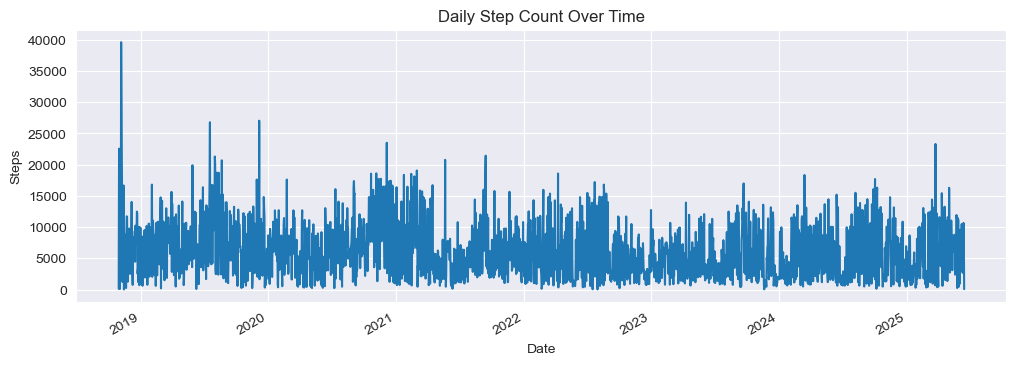

In [49]:
df_daily["steps"].plot(title="Daily Step Count Over Time", figsize=(12, 4))
plt.ylabel("Steps")
plt.xlabel("Date")
plt.grid(True)
plt.show()


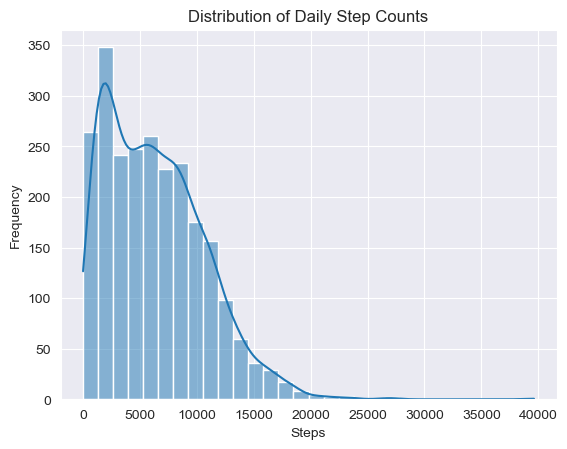

In [50]:
sns.histplot(df_daily["steps"], bins=30, kde=True)
plt.title("Distribution of Daily Step Counts")
plt.xlabel("Steps")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


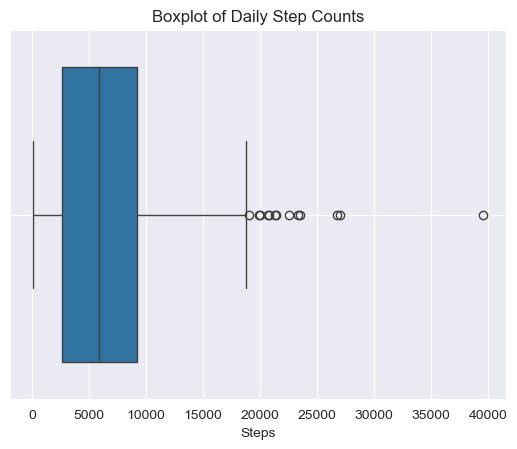

In [51]:
sns.boxplot(x=df_daily["steps"])
plt.title("Boxplot of Daily Step Counts")
plt.xlabel("Steps")
plt.grid(True)
plt.show()


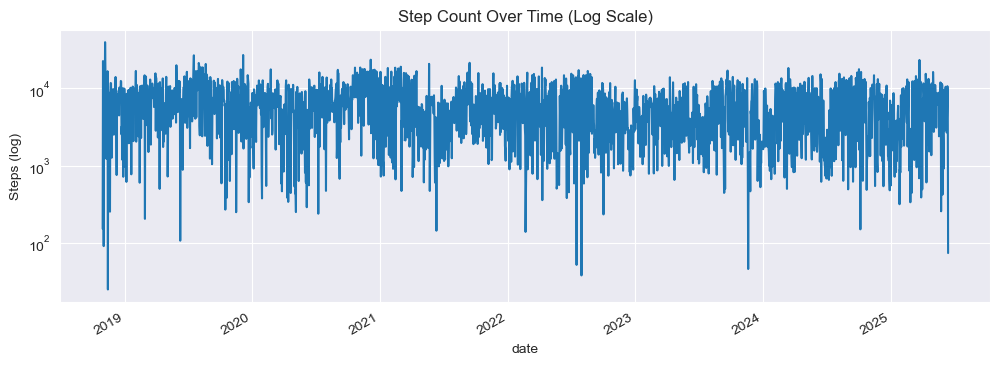

In [52]:
df_daily["steps"].plot(logy=True, title="Step Count Over Time (Log Scale)", figsize=(12, 4))
plt.ylabel("Steps (log)")
plt.grid(True)
plt.show()


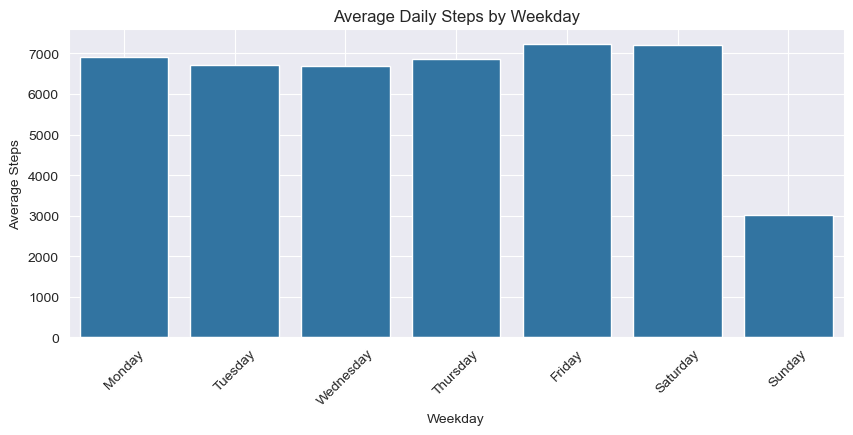

In [53]:
# Neue Spalte für Wochentag (0 = Montag, 6 = Sonntag)
df_daily["weekday"] = df_daily.index.dayofweek
df_daily["weekday_name"] = df_daily.index.day_name()

# Gruppieren & Mittelwert berechnen
weekday_avg = df_daily.groupby("weekday_name")["steps"].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Plot: Durchschnittliche Schritte pro Wochentag
plt.figure(figsize=(10, 4))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values)
plt.title("Average Daily Steps by Weekday")
plt.ylabel("Average Steps")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

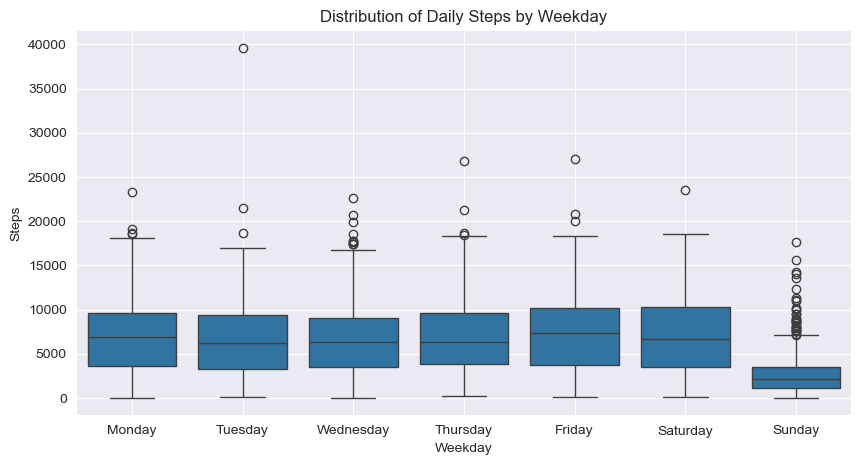

In [54]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="weekday_name", y="steps", data=df_daily,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Distribution of Daily Steps by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Steps")
plt.grid(True)
plt.show()


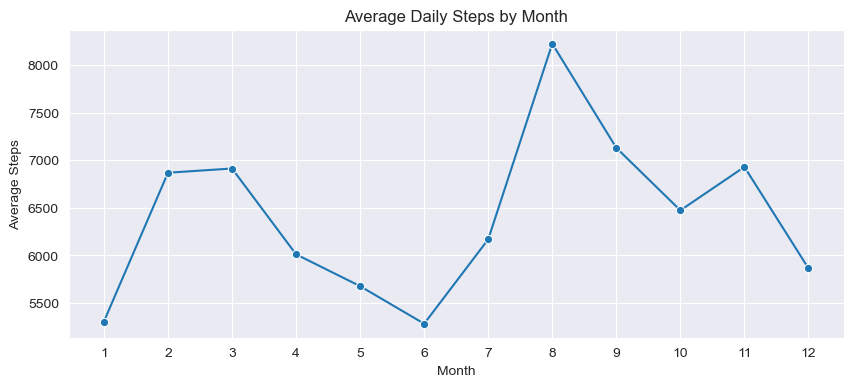

In [55]:
df_daily["month"] = df_daily.index.month
monthly_avg = df_daily.groupby(df_daily.index.month)["steps"].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker='o')
plt.title("Average Daily Steps by Month")
plt.xlabel("Month")
plt.ylabel("Average Steps")
plt.xticks(range(1,13))
plt.grid(True)
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_12736\178743680.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


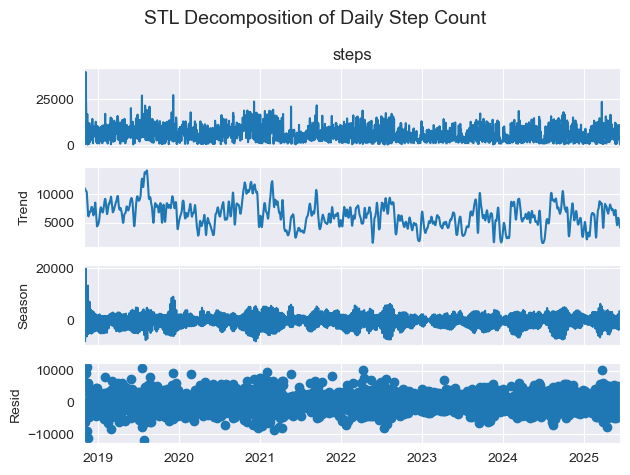

In [56]:
# STL mit Wochenperiodizität (7 Tage)
stl = STL(df_daily["steps"], period=7)
res = stl.fit()
res.plot()
plt.suptitle("STL Decomposition of Daily Step Count", fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 1200x400 with 0 Axes>

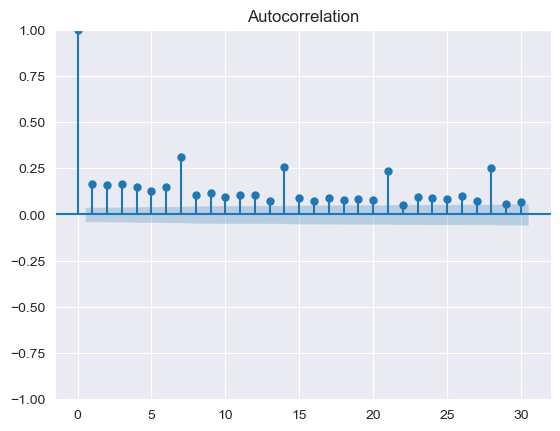

<Figure size 1200x400 with 0 Axes>

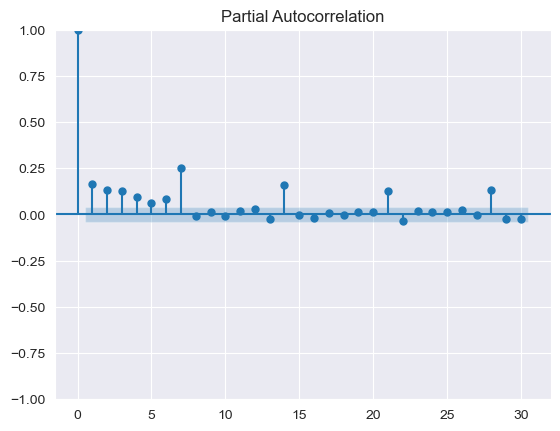

In [57]:
plt.figure(figsize=(12, 4))
plot_acf(df_daily["steps"], lags=30)
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(df_daily["steps"], lags=30)
plt.show()

In [58]:
adf_result = adfuller(df_daily["steps"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -4.7810461624202265
p-value: 5.91130620856961e-05


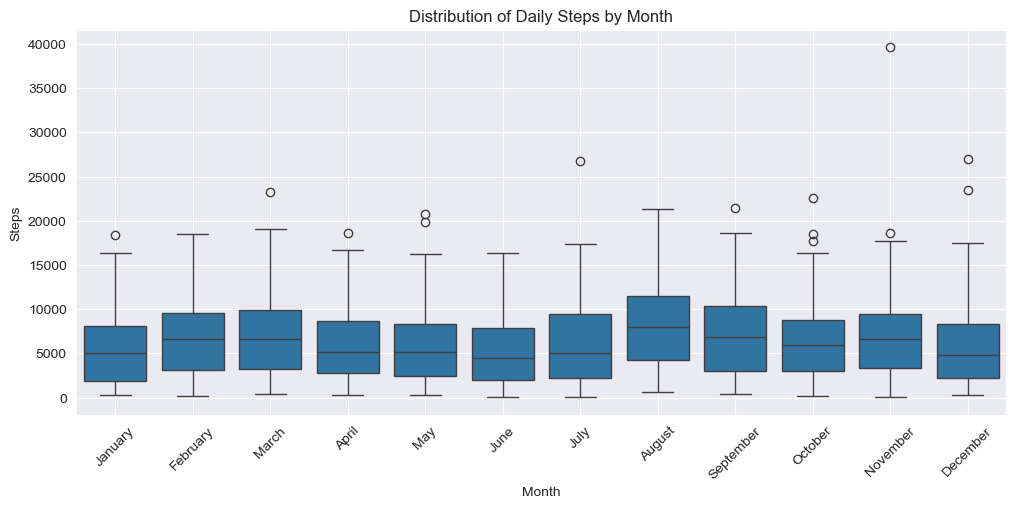

In [60]:
# Monat als Namen hinzufügen (für Plot)
df_daily["month_name"] = df_daily.index.month_name()

# Reihenfolge für schöne Darstellung
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

plt.figure(figsize=(12, 5))
sns.boxplot(x="month_name", y="steps", data=df_daily, order=month_order)
plt.title("Distribution of Daily Steps by Month")
plt.xlabel("Month")
plt.ylabel("Steps")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
